In [1]:
#get some library
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools

from ipywidgets import widgets
from IPython.display import display
from plotly.widgets import GraphWidget

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
init_notebook_mode(connected=True)

<IPython.core.display.Javascript object>

# SILAC Experiments

In [2]:
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')>2:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    return temp_id

#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')

#remove rubbish entires from a
#maxquant output
def clean(df):  
    #remove Only identified by site
    before,start = df.shape,df.shape
    col = 'Only identified by site'
    df = df[df[col] != '+'] 
    print_result(start, before, df, col)
    
    #remove hits from reverse database
    before = df.shape
    col = 'Reverse'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
        
    #remove contaminants (mainly keratine and bsa)
    before = df.shape
    col = 'Potential contaminant'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
    
    ##remove protein groups with less thatn 2 unique peptides
    #before = df.shape
    #col = 'Peptide counts (unique)'
    #df['unique'] = [int(n.split(';')[0]) for n in df[col]]
    #df = df[df['unique'] >= 2]
    #print_result(start, before, df, col)
    return df

In [3]:
#add back the description of the proteins
desc_dict = {}
path = 'TriTrypDB-32_TbruceiTREU927_AnnotatedProteins.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_desc = record.description.split('|')[4].strip()
        #print  (record.description.split('|'))
        desc_dict[temp_id]=temp_desc


In [4]:
#get glycosome data
ref_df = pd.read_csv('out_data/glycosome_experiment_extended.txt',sep='\t')    
ref_df['[Ortholog Group]']=ref_df['[Ortholog Group]'].astype('category')
ref_df['ortho_codes']=ref_df['[Ortholog Group]'].cat.codes
ref_df['[Input ID]']=[n.replace(' ','') for n in ref_df['[Input ID]']]
ref_df.set_index('[Input ID]',inplace=True)  
#print (ref_df.head())

lucia_experiments = pd.read_table('out_data/glycosome_experiment.txt',sep='\t')
lucia_experiments['[Input ID]']=lucia_experiments['GeneDB IDs']
lucia_experiments['[Input ID]']=[n.replace(' ','') for n in lucia_experiments['[Input ID]']]
lucia_experiments.set_index('[Input ID]',inplace=True)
#print (lucia_experiments.head())


ref_df = ref_df.join(lucia_experiments,how='left')
ref_df.drop_duplicates(subset=['[Gene ID]'],inplace=True)
ref_df.set_index('[Gene ID]',inplace=True,drop=True)
ref_df=ref_df[['Log2 H/L','Log10 (Int H*L)','Group', 'Glycosome status ']]
ref_df.head()

,Log2 H/L,Log10 (Int H*L),Group,Glycosome status
[Gene ID],,,,
Tb06.3A7.270,-0.113504,11.743189,i,red
Tb927.9.1350,0.020373,13.847976,i,red
Tb927.9.1360,0.034075,11.430029,i,red
Tb927.9.1380,0.158678,12.763610,i,red
Tb927.9.1410,0.002214,13.992089,i,red


# Experiment 1
## bait Tb927.11.12080

In [5]:
#read data and log transform for plots
df = pd.read_csv('silac_Tb927.3.2610/proteinGroups.txt',sep='\t')
df = clean(df)
df.head()

df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]


df['Gene_id_all'] = [    ';'.join([ clean_id(a) for a in n.split(';')]) for n in df['Protein IDs' ]  ]  
df['Gene_desc_all'] = [    '; '.join([ desc_dict[a].split('=')[1].strip() if a in desc_dict else 'none' for a in n.split(';')]) for n in df['Gene_id_all' ]  ]  

df['logInt']=np.log10(df['Intensity'])
df['logRatio_1']=np.log2(df['Ratio H/L normalized 1'])
df['logRatio_2']=np.log2(df['Ratio H/L normalized 2'])
df['logRatio_3']=np.log2(df['Ratio H/L normalized 3'])
df['logScore']=np.log10(df['Score'])
df.head()
print (df.shape)

removed  46 Only identified by site
tot  46  entries removed
---------------
removed  19 Reverse
tot  65  entries removed
---------------
removed  54 Potential contaminant
tot  119  entries removed
---------------
(1916, 121)


In [6]:
#get transmembrane and peptide signal from TryTripDB
tm = pd.read_csv('GeneByLocusTag_Summary.txt',sep='\t')
tm.drop_duplicates(subset=['[Input ID]'],inplace=True)
tm.set_index('[Input ID]',inplace=True)

df['[Input ID]'] = df['Gene_id']
df.set_index('[Input ID]',inplace=True)
df = df.join(tm, how='left')
df['[SignalP Peptide]'] = [1 if str(n) != 'nan' else 0 for n in df['[SignalP Peptide]'] ] 

In [7]:
#add number of unique peptide identified
df['unique'] = [int(n.split(';')[0]) for n in df['Peptide counts (unique)']]

In [8]:
#select some fielsd from the full output
selection = df[['Gene_desc', 'unique',  
                'logRatio_1', 'logRatio_2', 'logRatio_3','Score',
                'logScore', 'logInt',
                '[SignalP Peptide]','[# TM Domains]', 'Gene_id_all', 'Gene_desc_all']]
selection.dropna(inplace=True)

selection['logratio_mean']=selection[['logRatio_1', 'logRatio_2', 'logRatio_3']].mean(axis=1)
selection.sort_values('logratio_mean', inplace=True, ascending =False)
#selection=selection.join(ref_df, how='left')
#selection.to_csv('silac_Tb927.3.2610/silac_clean.csv')
selection.head(5)

,Gene_desc,unique,logRatio_1,logRatio_2,logRatio_3,Score,logScore,logInt,[SignalP Peptide],[# TM Domains],Gene_id_all,Gene_desc_all,logratio_mean
[Input ID],,,,,,,,,,,,,
Tb927.3.2610,GPI inositol deacylase 2,11,4.032982,4.101566,3.697440,47.272,1.674604,7.514096,0,10.0,Tb927.3.2610,GPI inositol deacylase 2,3.943996
Tb927.5.1640,"hypothetical protein, conserved",13,1.664119,1.554736,1.212445,54.324,1.734992,6.552644,0,0.0,Tb927.5.1640,"hypothetical protein, conserved",1.477100
Tb11.v5.0831,"kinesin motor domain containing protein, putative",4,1.182311,1.149650,1.376568,45.833,1.661178,6.835729,0,0.0,Tb11.v5.0831;Tb927.3.3400,"kinesin motor domain containing protein, putat...",1.236176
Tb927.11.12820,ribonucleoside-diphosphate reductase small chain,4,0.732834,1.247138,1.453702,20.165,1.304598,6.042260,0,1.0,Tb927.11.12820;Tb927.11.12810;Tb927.11.12800;T...,ribonucleoside-diphosphate reductase small cha...,1.144558
Tb927.10.9980,"hypothetical protein, conserved",14,0.966800,0.967611,0.982437,123.060,2.090117,7.427048,0,0.0,Tb927.10.9980,"hypothetical protein, conserved",0.972283


In [9]:
#replace missing values with average
#t-test 3 replicates versus 0,0,0
from scipy import stats
selection[['logRatio_1', 'logRatio_2', 'logRatio_3']] =selection[['logRatio_1', 'logRatio_2', 'logRatio_3']].fillna(selection[['logRatio_1', 'logRatio_2', 'logRatio_3']].mean())
statistics = []
pvalues = []
for prot in selection.index.values:
    statistic, pvalue = stats.ttest_ind(selection[['logRatio_1', 'logRatio_2', 'logRatio_3']].loc[prot].values,np.array([0,0,0]))
    statistics.append(statistic)
    pvalues.append(pvalue)
selection['pvalues']=pvalues
selection['statistics']=statistics

In [10]:
selection['log_pvalues']=-np.log10(selection['pvalues'])

In [11]:
from statsmodels.sandbox.stats.multicomp import multipletests
padj = multipletests(selection['pvalues'], method='bonferroni')
selection['padj']=padj[1]

In [12]:
selection[selection['padj']<0.05].head(10)

,Gene_desc,unique,logRatio_1,logRatio_2,logRatio_3,Score,logScore,logInt,[SignalP Peptide],[# TM Domains],Gene_id_all,Gene_desc_all,logratio_mean,pvalues,statistics,log_pvalues,padj
[Input ID],,,,,,,,,,,,,,,,,
Tb927.3.2610,GPI inositol deacylase 2,11,4.032982,4.101566,3.697440,47.272,1.674604,7.514096,0,10.0,Tb927.3.2610,GPI inositol deacylase 2,3.943996,5.986462e-06,31.587934,5.222830,0.003364
Tb11.v5.0831,"kinesin motor domain containing protein, putative",4,1.182311,1.149650,1.376568,45.833,1.661178,6.835729,0,0.0,Tb11.v5.0831;Tb927.3.3400,"kinesin motor domain containing protein, putat...",1.236176,6.326514e-05,17.453617,4.198836,0.035555
Tb927.10.9980,"hypothetical protein, conserved",14,0.966800,0.967611,0.982437,123.060,2.090117,7.427048,0,0.0,Tb927.10.9980,"hypothetical protein, conserved",0.972283,4.479531e-09,191.297765,8.348767,0.000003
Tb927.3.5040,"hypothetical protein, conserved",23,0.853756,0.862273,0.939227,62.672,1.797074,7.577319,0,0.0,Tb927.3.5040,"hypothetical protein, conserved",0.885085,5.304168e-06,32.561322,5.275383,0.002981
Tb927.10.13250,"hypothetical protein, conserved",23,0.761541,0.690194,0.812704,89.504,1.951842,6.996148,0,0.0,Tb927.10.13250,"hypothetical protein, conserved",0.754813,2.901053e-05,21.247230,4.537444,0.016304
Tb927.9.1350,"hypothetical protein, conserved",29,0.684460,0.740884,0.691266,166.610,2.221701,7.975808,0,0.0,Tb927.9.1350,"hypothetical protein, conserved",0.705537,2.411167e-06,39.675439,5.617773,0.001355
Tb927.11.2330,"molybdopterin synthase sulphurylase protein, p...",13,0.592923,0.643764,0.659194,102.910,2.012458,7.488790,0,1.0,Tb927.11.2330,"molybdopterin synthase sulphurylase protein, p...",0.631960,6.003063e-06,31.565999,5.221627,0.003374
Tb927.4.2750,"hypothetical protein, conserved",8,0.611928,0.647545,0.603027,63.004,1.799368,6.666855,0,0.0,Tb927.4.2750,"hypothetical protein, conserved",0.620833,1.377566e-06,45.647041,5.860888,0.000774
Tb927.5.4560,"guanine deaminase, putative",18,0.558562,0.566377,0.637935,193.790,2.287331,7.348383,0,0.0,Tb927.5.4560;Tb11.v5.0409;Tb05.5K5.200,"guanine deaminase, putative; guanine deaminase...",0.587624,2.022518e-05,23.266567,4.694108,0.011367


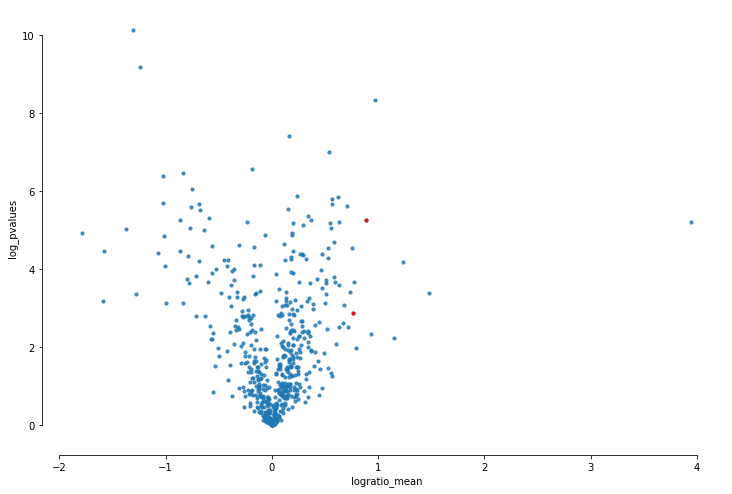

In [13]:
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='logratio_mean', y='log_pvalues', 
            fit_reg=False, data = selection,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
sns.regplot(x='logratio_mean', y='log_pvalues', 
            fit_reg=False, data = selection.loc[['Tb927.3.5040',
'Tb927.4.2890']],
            ax=ax, scatter_kws={'s':10,'color':'red'})

plt.show()

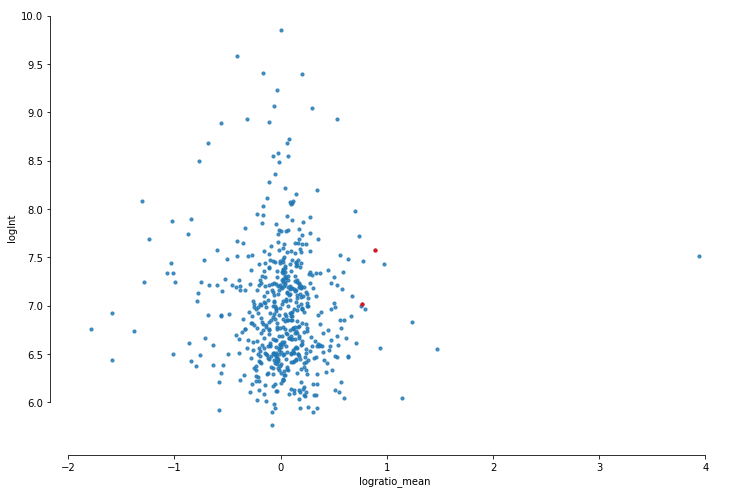

In [14]:
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='logratio_mean', y='logInt', 
            fit_reg=False, data = selection,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
sns.regplot(x='logratio_mean', y='logInt', 
            fit_reg=False, data = selection.loc[['Tb927.3.5040',
'Tb927.4.2890']],
            ax=ax, scatter_kws={'s':10,'color':'red'})

plt.show()


# Experiment Reproducibility

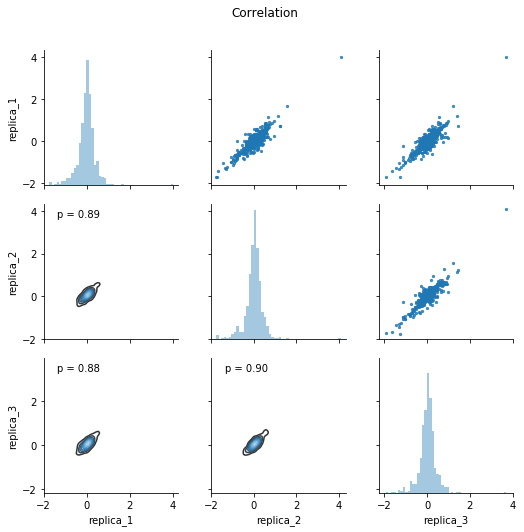

In [15]:
#select dataset
temp = selection[['logRatio_1',
           'logRatio_2',
           'logRatio_3']]

#rename dataset columns with the first author name
temp.columns = ['replica_1', 'replica_2', 'replica_3']

#plot the correlation
def corrfunc(x, y, **kws):
    corr = np.corrcoef(x, y)
    r = corr[0][1]
    ax = plt.gca()
    ax.annotate("p = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    
g = sns.PairGrid(temp.dropna(), palette=["red"])
g.map_upper(plt.scatter, s=5,alpha=0.8)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Correlation') 
plt.show()


In [16]:
mike_selection ='''Tb927.11.11480
Tb927.8.1090
Tb927.3.5040
Tb927.7.1220
Tb927.7.7320
Tb927.1.1500
Tb927.8.1210
Tb927.3.4120
Tb927.7.5290
Tb927.11.11720
Tb927.2.2530
Tb927.10.14740
Tb927.6.2380
Tb927.11.7690
Tb927.4.2890
Tb927.8.8150
Tb927.7.5450
Tb927.4.2850
'''.split()
selection[['logRatio_1', 'logRatio_2', 'logRatio_3','Gene_desc','[SignalP Peptide]','[# TM Domains]']].loc[mike_selection]

,logRatio_1,logRatio_2,logRatio_3,Gene_desc,[SignalP Peptide],[# TM Domains]
[Input ID],,,,,,
Tb927.11.11480,NaN,NaN,NaN,NaN,NaN,NaN
Tb927.8.1090,NaN,NaN,NaN,NaN,NaN,NaN
Tb927.3.5040,0.853756,0.862273,0.939227,"hypothetical protein, conserved",0.0,0.0
Tb927.7.1220,NaN,NaN,NaN,NaN,NaN,NaN
Tb927.7.7320,NaN,NaN,NaN,NaN,NaN,NaN
Tb927.1.1500,0.072312,0.258700,-0.202041,"conserved protein, unknown function",0.0,0.0
Tb927.8.1210,NaN,NaN,NaN,NaN,NaN,NaN
Tb927.3.4120,0.147828,0.195222,0.223423,"hypothetical protein, conserved",0.0,1.0
Tb927.7.5290,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
selection.to_csv('silac_Tb927.3.2610/Analysis_1.csv')

## Make interactive Figure

In [18]:
#interactive plot
trace_1 = go.Scatter(
    x=selection.logratio_mean,
    y=selection.log_pvalues,
    mode='markers',
    name='Vulacano Plot',
    text = [a + ' ' +b + ' '+str(round(c,1)) for a,b,c in zip(selection.index.values, selection.Gene_desc, selection.logScore )],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = np.log10(selection.logScore), #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[selection.logratio_mean.loc['Tb927.3.2610']],
    y=[selection.log_pvalues.loc['Tb927.3.2610']],
    mode='markers+text',
    name='Tb927.3.2610',
    text=['Bait'],
    textposition='bottom center'
)



layout = dict(title='Vulacano SILAC')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

In [19]:
#interactive plot
trace_1 = go.Scatter(
    x=selection.logratio_mean,
    y=selection.logInt,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b + ' '+str(round(c,1)) for a,b,c in zip(selection.index.values, selection.Gene_desc, selection.logScore )],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = np.log10(selection.logScore), #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[selection.logratio_mean.loc['Tb927.3.2610']],
    y=[selection.logInt.loc['Tb927.3.2610']],
    mode='markers+text',
    name='Tb927.3.2610',
    text=['Bait'],
    textposition='bottom center'
)



layout = dict(title='MA SILAC')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

# Analysis with intensities

In [20]:
#select some fielsd from the full output
selection = df[['Gene_desc', 'unique',  
                'Intensity L 1',
                'Intensity H 1',
                'Intensity L 2',
                'Intensity H 2',
                'Intensity L 3',
                'Intensity H 3','Score',
                'logScore', 'logInt',
                '[SignalP Peptide]', '[# TM Domains]', 'Gene_id_all', 'Gene_desc_all']]

replace_1 = selection['Intensity L 1'][selection['Intensity L 1']>0].min()
replace_2 =selection['Intensity L 2'][selection['Intensity L 2']>0].min()
replace_3 =selection['Intensity L 3'][selection['Intensity L 3']>0].min()

replace_3 = selection['Intensity H 1'][selection['Intensity H 1']>0].min()
replace_4 =selection['Intensity H 2'][selection['Intensity H 2']>0].min()
replace_5 =selection['Intensity H 3'][selection['Intensity H 3']>0].min()

selection['Intensity L 1'].fillna(replace_1,inplace=True)
selection['Intensity L 2'].fillna(replace_2,inplace=True)
selection['Intensity L 3'].fillna(replace_3,inplace=True)
selection['Intensity L 1'].replace(0,replace_1,inplace=True)
selection['Intensity L 2'].replace(0,replace_2,inplace=True)
selection['Intensity L 3'].replace(0,replace_3,inplace=True)

selection['Intensity H 1'].fillna(replace_3,inplace=True)
selection['Intensity H 2'].fillna(replace_4,inplace=True)
selection['Intensity H 3'].fillna(replace_5,inplace=True)
selection['Intensity H 1'].replace(0,replace_3,inplace=True)
selection['Intensity H 2'].replace(0,replace_4,inplace=True)
selection['Intensity H 3'].replace(0,replace_5,inplace=True)


selection['Intensity HL 1']=np.log2(selection['Intensity H 1']/selection['Intensity L 1'])
selection['Intensity HL 2']=np.log2(selection['Intensity H 2']/selection['Intensity L 2'])
selection['Intensity HL 3']=np.log2(selection['Intensity H 3']/selection['Intensity L 3'])
selection['logratio_mean']=selection[['Intensity HL 1','Intensity HL 2','Intensity HL 3']].mean(axis=1)
selection.head(5)

,Gene_desc,unique,Intensity L 1,Intensity H 1,Intensity L 2,Intensity H 2,Intensity L 3,Intensity H 3,Score,logScore,logInt,[SignalP Peptide],[# TM Domains],Gene_id_all,Gene_desc_all,Intensity HL 1,Intensity HL 2,Intensity HL 3,logratio_mean
[Input ID],,,,,,,,,,,,,,,,,,,
Tb927.5.4460,"major vault protein, putative",33,7436700,5840700,6470200,4938900,10843,15659,116.060,2.064683,7.392451,0,0.0,Tb927.5.4460;Tb05.5K5.110;Tb11.v5.0866,"major vault protein, putative; major vault pro...",-0.348521,-0.389621,0.530228,-0.069305
Tb927.5.4480,"paraflagellar rod component par4, putative",19,253870,205350,625220,424640,2108100,1657600,93.565,1.971113,6.722198,0,0.0,Tb927.5.4480;Tb05.5K5.130,"paraflagellar rod component par4, putative; pa...",-0.306005,-0.558124,-0.346847,-0.403659
Tb927.5.4500,"ras-like small GTPase, putative",7,265220,449670,207920,549160,711750,1444000,43.107,1.634548,6.559643,1,0.0,Tb927.5.4500;Tb05.5K5.150,"ras-like small GTPase, putative; small GTP-bin...",0.761677,1.401198,1.020628,1.061168
Tb927.5.4520,Kinetochore interacting protein 1,10,396570,954450,548220,1150700,10843,15659,22.890,1.359646,6.484286,0,0.0,Tb927.5.4520;Tb05.5K5.160,Kinetochore interacting protein 1; hypothetica...,1.267094,1.069685,0.530228,0.955669
Tb927.5.4560,"guanine deaminase, putative",18,2723200,4167600,3931400,5781700,2116700,3583700,193.790,2.287331,7.348383,0,0.0,Tb927.5.4560;Tb11.v5.0409;Tb05.5K5.200,"guanine deaminase, putative; guanine deaminase...",0.613914,0.556451,0.759633,0.643333


In [21]:
#replace missing values with average
#t-test 3 replicates versus 0,0,0
from scipy import stats
selection[['Intensity HL 1', 'Intensity HL 2', 'Intensity HL 3']] =selection[['Intensity HL 1', 'Intensity HL 2', 'Intensity HL 3']].fillna(selection[['Intensity HL 1', 'Intensity HL 2', 'Intensity HL 3']].mean())
statistics = []
pvalues = []
for prot in selection.index.values:
    statistic, pvalue = stats.ttest_ind(selection[['Intensity HL 1', 'Intensity HL 2', 'Intensity HL 3']].loc[prot].values,np.array([0,0,0]))
    statistics.append(statistic)
    pvalues.append(pvalue)
selection['pvalues']=pvalues
selection['statistics']=statistics
selection['log_pvalues']=-np.log10(selection['pvalues'])
from statsmodels.sandbox.stats.multicomp import multipletests
padj = multipletests(selection['pvalues'], method='bonferroni')
selection['padj']=padj[1]
selection.head()

,Gene_desc,unique,Intensity L 1,Intensity H 1,Intensity L 2,Intensity H 2,Intensity L 3,Intensity H 3,Score,logScore,...,Gene_id_all,Gene_desc_all,Intensity HL 1,Intensity HL 2,Intensity HL 3,logratio_mean,pvalues,statistics,log_pvalues,padj
[Input ID],,,,,,,,,,,,,,,,,,,,,
Tb927.5.4460,"major vault protein, putative",33,7436700,5840700,6470200,4938900,10843,15659,116.060,2.064683,...,Tb927.5.4460;Tb05.5K5.110;Tb11.v5.0866,"major vault protein, putative; major vault pro...",-0.348521,-0.389621,0.530228,-0.069305,0.828639,-0.231014,0.081635,1.000000
Tb927.5.4480,"paraflagellar rod component par4, putative",19,253870,205350,625220,424640,2108100,1657600,93.565,1.971113,...,Tb927.5.4480;Tb05.5K5.130,"paraflagellar rod component par4, putative; pa...",-0.306005,-0.558124,-0.346847,-0.403659,0.006667,-5.166683,2.176056,1.000000
Tb927.5.4500,"ras-like small GTPase, putative",7,265220,449670,207920,549160,711750,1444000,43.107,1.634548,...,Tb927.5.4500;Tb05.5K5.150,"ras-like small GTPase, putative; small GTP-bin...",0.761677,1.401198,1.020628,1.061168,0.004641,5.713705,2.333383,1.000000
Tb927.5.4520,Kinetochore interacting protein 1,10,396570,954450,548220,1150700,10843,15659,22.890,1.359646,...,Tb927.5.4520;Tb05.5K5.160,Kinetochore interacting protein 1; hypothetica...,1.267094,1.069685,0.530228,0.955669,0.012257,4.339580,1.911616,1.000000
Tb927.5.4560,"guanine deaminase, putative",18,2723200,4167600,3931400,5781700,2116700,3583700,193.790,2.287331,...,Tb927.5.4560;Tb11.v5.0409;Tb05.5K5.200,"guanine deaminase, putative; guanine deaminase...",0.613914,0.556451,0.759633,0.643333,0.000442,10.638867,3.354587,0.846854


In [22]:
#interactive plot
trace_1 = go.Scatter(
    x=selection.logratio_mean,
    y=selection.log_pvalues,
    mode='markers',
    name='Vulacano Plot',
    text = [a + ' ' +b + ' '+str(round(c,1)) for a,b,c in zip(selection.index.values, selection.Gene_desc, selection.logScore )],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = np.log10(selection.logScore), #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[selection.logratio_mean.loc['Tb927.3.2610']],
    y=[selection.log_pvalues.loc['Tb927.3.2610']],
    mode='markers+text',
    name='Tb927.3.2610',
    text=['Bait'],
    textposition='bottom center'
)



layout = dict(title='Vulacano SILAC')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

In [23]:
#interactive plot
trace_1 = go.Scatter(
    x=selection.logratio_mean,
    y=selection.logInt,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b + ' '+str(round(c,1)) for a,b,c in zip(selection.index.values, selection.Gene_desc, selection.logScore )],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = np.log10(selection.logScore), #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[selection.logratio_mean.loc['Tb927.3.2610']],
    y=[selection.logInt.loc['Tb927.3.2610']],
    mode='markers+text',
    name='Tb927.3.2610',
    text=['Bait'],
    textposition='bottom center'
)



layout = dict(title='MA SILAC')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

In [24]:
selection.to_csv('silac_Tb927.3.2610/Analysis_2.csv')